# 「静止、歩行、階段、横たわる、カメラで商品を写す、カメラで上にある看板を写す」の6つの分類を行うモデル
## 使用データ

Buildingデータ（猪股）*20

Homeデータ(猪股)*20

カメラで商品を写す(猪股、大澤、千葉、佐々木　各30セット)*120

カメラで上にある看板を写す(猪股、大澤、千葉、佐々木　各30セット)*120

## 訓練データ種類

Buildingデータ（猪股）*18

Homeデータ(猪股)*18

カメラで商品を写す(猪股、大澤、千葉、佐々木　各29セット)*116

カメラで上にある看板を写す(猪股、大澤、千葉、佐々木　各29セット)*116

# テストデータ種類

Buildingデータ（猪股）*2

Homeデータ(猪股)*2

カメラで商品を写す(猪股、大澤、千葉、佐々木　各1セット)*4

カメラで上にある看板を写す(猪股、大澤、千葉、佐々木　各1セット)*4


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statistics
import sklearn as sk
import os
import glob
import math
import collections
import pylab
import tensorflow as tf
keras = tf.keras
import keras.backend as K
import scipy.stats as stats

from pandas import DataFrame
from pprint import pprint

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score as accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from tensorflow.keras.layers import Input, concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model

from keras import metrics
from keras import models, layers
from keras.layers import Dropout, Embedding, LSTM, Bidirectional, Activation
from keras.models import Sequential
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import sequence

import warnings
warnings.simplefilter('ignore')

In [2]:
def minmax(value, max_, min_):
    return (value - min_)/(max_ - min_)

In [3]:
def prepro_just(trte, window_size, mima):
    def append_data(data_a, data_b):
        for i in range(len(data_b)):
            data_a.append(data_b[i])

        return data_a
    
    file = glob.glob('data/'+trte+'/*.csv')
    
    data_acc_fin = []
    data_do_fin = []
    data_rot_fin = []
    data_acc_z_fin = []
    label_fin = []
    
    for file_num in range(len(file)):
        df = pd.read_csv(file[file_num])
        if '姿勢なし' in df.values:
            continue
            
        df = df.replace({'直立':0, '歩行':1, '階段 - 下り':2, '階段 - 上り':2, '着席':0, '寝る':3, 'camera':4, 'kanban':5})
        df = df[['date', 'label', 's_movement', 'do_alpha', 'do_beta', 'do_gamma', 
                 'acc_g_x', 'acc_g_y', 'acc_g_z', 'acc_x', 'acc_y', 'acc_z', 'rot_alpha', 'rot_beta', 'rot_gamma']]
        
        # acceleration composite 
        df['acc_composite'] = (df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2) ** 1/2
        df['acc_composite_minmax'] = minmax(df['acc_composite'], 319.57, 0)
        
        # rotation pre
        df['do_beta_pre'] = (df['do_beta']+180)/360
        df['do_gamma_pre'] = (df['do_gamma']+90)/180
        
        df['rot_beta_pre'] = (df['rot_beta']+300)/600
        df['rot_gamma_pre'] = (df['rot_gamma']+300)/600
        
        # standardization
        df['acc_z_sta_min'] = df['acc_z'] + 18
        df['acc_z_sta_max'] = df['acc_z'] + 26
        
        df['acc_z_sta_min_minmax'] = minmax(df['acc_z_sta_min'], 44, 0)
        df['acc_z_sta_max_minmax'] = minmax(df['acc_z_sta_max'], 51, 7)
        
        if mima=='min':
            data_acc = np.array(df[['acc_composite_minmax']])
            data_do = np.array(df[['do_beta_pre', 'do_gamma_pre']])
            data_rot = np.array(df[['rot_beta_pre', 'rot_gamma_pre']])
            data_acc_z = np.array(df[['acc_z_sta_min_minmax']])
        elif mima=='max':
            data_acc = np.array(df[['acc_composite_minmax']])
            data_do = np.array(df[['do_beta_pre', 'do_gamma_pre']])
            data_rot = np.array(df[['rot_beta_pre', 'rot_gamma_pre']])
            data_acc_z = np.array(df[['acc_z_sta_max_minmax']])
        label = np.array(df[['label']])
        
        data_acc = [data_acc[i:i+window_size] for i in range(len(data_acc)-window_size)]
        data_do = [data_do[i:i+window_size] for i in range(len(data_do)-window_size)]
        data_rot = [data_rot[i:i+window_size] for i in range(len(data_rot)-window_size)]
        data_acc_z = [data_acc_z[i:i+window_size] for i in range(len(data_acc_z)-window_size)]
        
        data_label = [label[i+window_size] for i in range(len(label)-window_size)]
        
        data_acc = append_data(data_acc_fin, data_acc)
        data_do = append_data(data_do_fin, data_do)
        data_rot = append_data(data_rot_fin, data_rot)
        data_acc_z = append_data(data_acc_z_fin, data_acc_z)
        data_label = append_data(label_fin, data_label)
    
    data_acc_fin = np.array(data_acc)
    data_do_fin = np.array(data_do)
    data_rot_fin = np.array(data_rot)
    data_acc_z_fin = np.array(data_acc_z)
    
    label_fin = np.array(label_fin)
    
    return data_acc_fin, data_do_fin, data_rot_fin, data_acc_z_fin, label_fin

In [4]:
window_size = 10

title = 'stand_max_comp_4er'
train_acc, train_do, train_rot, train_acc_z, train_label = prepro_just('train', window_size, 'max')
test_acc, test_do, test_rot, test_acc_z, test_label = prepro_just('test', window_size, 'max')

In [5]:
class_num = 6
n_hidden = 100

In [6]:
# 入力を定義
input_acc = Input(shape=(window_size,1))
input_do = Input(shape=(window_size,2))
input_rot = Input(shape=(window_size,2))
input_acc_z = Input(shape=(window_size,1))


# 入力1から結合前まで(Conv1D)
acc = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu')(input_acc)
acc = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu')(acc)

acc = Model(inputs=input_acc, outputs=acc)

# 入力2から結合前まで(Conv1D)
do = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu')(input_do)
do = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu')(do)

do = Model(inputs=input_do, outputs=do)

# 入力1から結合前まで(Conv1D)
rot = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu')(input_rot)
rot = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu')(rot)

rot = Model(inputs=input_rot, outputs=rot)

# 入力2から結合前まで(Conv1D)
acc_z = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu')(input_acc_z)
acc_z = tf.keras.layers.Conv1D(filters=64, kernel_size=3, dilation_rate=2, activation='relu')(acc_z)

acc_z = Model(inputs=input_acc_z, outputs=acc_z)

# 結合
combined = concatenate([acc.output, do.output, rot.output, acc_z.output])

# # 密結合
z = tf.keras.layers.LSTM(units=n_hidden, return_sequences=True)(combined)
z = tf.keras.layers.LSTM(units=n_hidden, return_sequences=False)(z)

z = tf.keras.layers.Dense(units=10, activation='relu')(z)
z = tf.keras.layers.Dense(class_num, activation='softmax')(z)

# モデル定義とコンパイル
rnn = tf.keras.Model(inputs=[acc.input, do.input, rot.input, acc_z.input], outputs=z)
rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
rnn.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10, 1)]      0                                            
____________________________________________________________________________________________

In [7]:
rnn.compile(loss='sparse_categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
rnn.fit([train_acc, train_do, train_rot, train_acc_z], train_label,
          batch_size=64,
          epochs=10000,
          validation_split=0.1,
          callbacks=[callback]
       )

predict_classes = rnn.predict([test_acc, test_do, test_rot, test_acc_z])
true_classes = test_label

pre_cla = []

for i in range(len(predict_classes)):
    max_ = np.amax(predict_classes[i])
    for j in range(len(predict_classes[i])):
        if max_==predict_classes[i][j]:
            pre_cla.append(j)

predict_classes = np.array(pre_cla)

Epoch 1/10000
827/827 [==============================] - 7s 8ms/step - loss: 0.7947 - accuracy: 0.6288 - val_loss: 0.6349 - val_accuracy: 0.6670
Epoch 2/10000
827/827 [==============================] - 6s 7ms/step - loss: 0.5729 - accuracy: 0.7217 - val_loss: 0.5762 - val_accuracy: 0.7024
Epoch 3/10000
827/827 [==============================] - 6s 8ms/step - loss: 0.5332 - accuracy: 0.7448 - val_loss: 0.5959 - val_accuracy: 0.7095
Epoch 4/10000
827/827 [==============================] - 7s 8ms/step - loss: 0.4993 - accuracy: 0.7724 - val_loss: 0.5444 - val_accuracy: 0.7405
Epoch 5/10000
827/827 [==============================] - 7s 8ms/step - loss: 0.4670 - accuracy: 0.7930 - val_loss: 0.4492 - val_accuracy: 0.8065
Epoch 6/10000
827/827 [==============================] - 7s 8ms/step - loss: 0.4381 - accuracy: 0.8083 - val_loss: 0.4510 - val_accuracy: 0.7986
Epoch 7/10000
827/827 [==============================] - 7s 9ms/step - loss: 0.4179 - accuracy: 0.8200 - val_loss: 0.4425 - val_ac

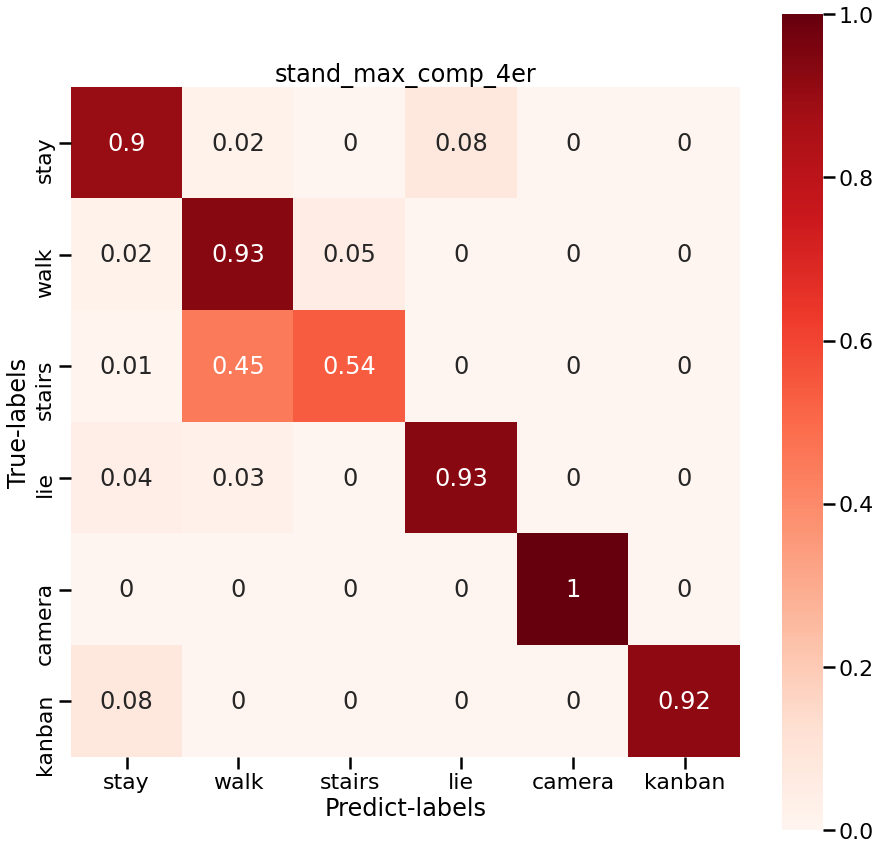

In [11]:
target_names = ['stay', 'walk', 'stairs', 'lie', 'camera','kanban']

def print_cmx(y_true, y_pred, labels, TagID):
    cmx_data = confusion_matrix(y_true, y_pred)
    
    cmx_data = cmx_data.astype('float') / cmx_data.sum(axis=1)[:, np.newaxis]
    
    cmx_data = cmx_data.round(2)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    plt.figure(figsize = (15,15))
    sn.heatmap(df_cmx, annot=True, fmt='g', square = True, cmap='Reds', vmin=0.0, vmax=1.0)
    sn.set_context('poster')
    
    plt.ylim(6, 0)
    plt.xlabel("Predict-labels")
    plt.ylabel("True-labels")
    
    plt.title(TagID)
    
#     plt.savefig('../../../../data_image/confusion_matrix/200708/'+title+'.png')    
    
    plt.show()    
#     dd
    return 
    
print_cmx(true_classes, predict_classes, target_names, title)

In [10]:
from sklearn.metrics import classification_report
import pandas as pd
import pprint

print(classification_report(true_classes, predict_classes))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1400
           1       0.70      0.93      0.80      2066
           2       0.90      0.54      0.68      1724
           3       0.87      0.93      0.90       852
           4       1.00      1.00      1.00        58
           5       0.95      0.92      0.93        75

    accuracy                           0.82      6175
   macro avg       0.89      0.87      0.87      6175
weighted avg       0.84      0.82      0.81      6175

